# Co-Authorship Network Analysis

این کد شبکه هم‌نویسندگی را تولید می‌کند. پس از اجرای آن، یک شبکه تولید خواهد شد که نیاز است آن را دانلود کنید. با استفاده از گفی می‌توانید آن را باز کنید. پس از باز کردن شبکه، پیشنهاد می‌شود الگوریتم‌های مختلف مرتب‌سازی گراف را امتحان کنید؛ احتمالاً الگوریتم فورس اطلس ۲ بهترین نتیجه را خواهد داشت. پس از اعمال الگوریتم، اندازه گره‌ها را بر اساس مرکزیت درجه تنظیم کنید و مقیاس‌دهی کنید تا گره‌ها معنای بیشتری پیدا کنند. همچنین می‌توانید از بخش پایینی صفحه در گفی برچسب گره‌ها را قابل نمایش کنید و تنظیمات مربوط به اندازه و نوع فونت برچسب‌ها را تغییر دهید. در ادامه کدی قرار داده شده است که محاسبات را برای شما انجام می‌دهد. کافی است فایل خروجی را در آدرس مورد نظر قرار دهید و محاسبات کاکر و میکرو را انجام دهید و در گزارشتان استفاده کنید.
موفق باشید

In [6]:
import pandas as pd

def parse_wos_file(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    data, record = [], {}
    current_field = None

    field_mapping = {
        "PT": "start_new_record",
        "AB": "Abstract",
        "AF": "Authors",
        "TI": "Title",
        "SO": "Journal",
        "PY": "Year",
        "C1": "Addresses",
        "DI": "DOI",
        "DE": "Keywords",
        "TC": "Cite",
        "C3": "C3",
        "FU": "Funding",
        "WC": "Subject Category"
    }

    multi_line_fields = ['AF', 'C3', 'WC'] 

   
    continuation_logic = {
        'Authors': lambda prev, line: prev + '|' + line.strip(),
        'C3': lambda prev, line: prev + ' ' + line.strip(),
        'Subject_Category': lambda prev, line: prev + ' ' + line.strip(),
    }

    for line in lines:
        if len(line.strip()) == 0:
            continue  

        if len(line) < 3:
            continue  

        prefix, content = line[:2], line[3:].strip()

        if prefix in field_mapping:
            if prefix == "PT":
                if record:
                    data.append(record)
                record = {
                    'index': len(data) + 1,
                    'Abstract': '',
                    'Authors': '',
                    'C3': '',
                    'DOI': '',
                    'Funding': '',
                    'Journal': '',
                    'ISI_Keywords': '',
                    'Keywords': '',
                    'Year': '',
                    'Addresses': '',
                    'Title': '',
                    'Cite': '',
                    'Subject Category': ''
                }
                current_field = None
            else:
                record[field_mapping[prefix]] = content
                current_field = field_mapping[prefix] if prefix in multi_line_fields else None
        else:
            if line.startswith(" "):
                
                if current_field in continuation_logic:
                    record[current_field] = continuation_logic[current_field](record[current_field], line)
            else:
                current_field = None 

    if record:
        data.append(record)

    df = pd.DataFrame(data)

    df['Authors'] = df['Authors'].str.rstrip('|')
    df['Journal'] = df['Journal'].str.split(',').str[0]

    return df


def save_to_excel(df, output_filepath):
    df.to_excel(output_filepath, index=False, engine='openpyxl')

def process_wos_to_excel(wos_filepath, output_filepath):
    df = parse_wos_file(wos_filepath)
    save_to_excel(df, output_filepath)

if __name__ == "__main__":
    wos_filepath = './content/merged_output.txt'
    output_filepath = './content/output_wos_file.xlsx'
    process_wos_to_excel(wos_filepath, output_filepath)

PermissionError: [Errno 13] Permission denied: './content/output_wos_file.xlsx'

In [3]:
import networkx as nx

def load_graph(graphml_file):
    G = nx.read_graphml(graphml_file)
    return G

def get_giant_component(G):
    if nx.is_directed(G):
        largest_component = max(nx.weakly_connected_components(G), key=len)
    else:
        largest_component = max(nx.connected_components(G), key=len)

    G_giant = G.subgraph(largest_component).copy()
    return G_giant

def save_giant_component(G_giant, output_file):
    nx.write_graphml(G_giant, output_file)

# Main function
def main(graphml_file, output_file):
    G = load_graph(graphml_file)

    G_giant = get_giant_component(G)

    print(f"Original graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    print(f"Giant component has {G_giant.number_of_nodes()} nodes and {G_giant.number_of_edges()} edges.")

    save_giant_component(G_giant, output_file)
    print(f"Giant component saved to {output_file}")

graphml_file = './content/co_affiliation_network.graphml'  # Input GraphML file
output_file = './content/giant_component.graphml'             # Output GraphML file with giant component
main(graphml_file, output_file)


Original graph has 7270 nodes and 168445 edges.
Giant component has 7198 nodes and 168380 edges.
Giant component saved to ./content/giant_component.graphml


In [29]:
import pandas as pd
import networkx as nx

excel_file = './content/output_wos_file.xlsx'  # Replace with the path to your Excel file
df = pd.read_excel(excel_file)

G = nx.Graph()

for index, row in df.iterrows():
    
    authors_data = row['Authors']
    
    if isinstance(authors_data, str):
        authors = authors_data.split('|')
        authors = [author.strip() for author in authors]

        for i in range(len(authors)):
            for j in range(i + 1, len(authors)):
                G.add_edge(authors[i], authors[j])

# Save the graph to a GraphML file
nx.write_graphml(G, './content/C--authorship_network.graphml')

In [47]:
import pandas as pd
import networkx as nx

# Read the Excel file
excel_file = './content/output_wos_file.xlsx'  # Replace with the path to your Excel file
df = pd.read_excel(excel_file)


G = nx.Graph()


for index, row in df.iterrows():
    authors_data = row['Authors']
    

    if isinstance(authors_data, str):
        authors = authors_data.split('|')
        authors = [author.strip() for author in authors]

        for i in range(len(authors)):
            for j in range(i + 1, len(authors)):
                G.add_edge(authors[i], authors[j])


giant_component_nodes = max(nx.connected_components(G), key=len)


giant_component_subgraph = G.subgraph(giant_component_nodes).copy()

nx.write_graphml(giant_component_subgraph, './content/giant_component_authorship_network.graphml')

print("Giant component extracted and saved successfully.")


Organizations

In [2]:
import pandas as pd
import networkx as nx

excel_file = './content/output_wos_file.xlsx'  # Replace with the path to your Excel file
df = pd.read_excel(excel_file)

G = nx.Graph()

for index, row in df.iterrows():
    if isinstance(row['C3'], str):
        affiliations = row['C3'].split(';')
        affiliations = [affiliation.strip() for affiliation in affiliations]

        for i in range(len(affiliations)):
            for j in range(i + 1, len(affiliations)):
                G.add_edge(affiliations[i], affiliations[j])

nx.write_graphml(G, './content/co_affiliation_network.graphml')

print("Network saved as co_affiliation_network.net")


Network saved as co_affiliation_network.net


In [5]:
import pandas as pd
import networkx as nx

excel_file = './content/output_wos_file.xlsx'  # Replace with the path to your Excel file
df = pd.read_excel(excel_file)

G = nx.Graph()

for index, row in df.iterrows():
    if isinstance(row['Subject Category'], str):
        Subject_Category = row['Subject Category'].split(';')
        Subject_Category = [Subject_Category.strip() for Subject_Category in Subject_Category]

        for i in range(len(Subject_Category)):
            for j in range(i + 1, len(Subject_Category)):
                G.add_edge(Subject_Category[i], Subject_Category[j])

nx.write_pajek(G, './content/co_Subject_Category_network.net')


KeyError: 'Subject Category'

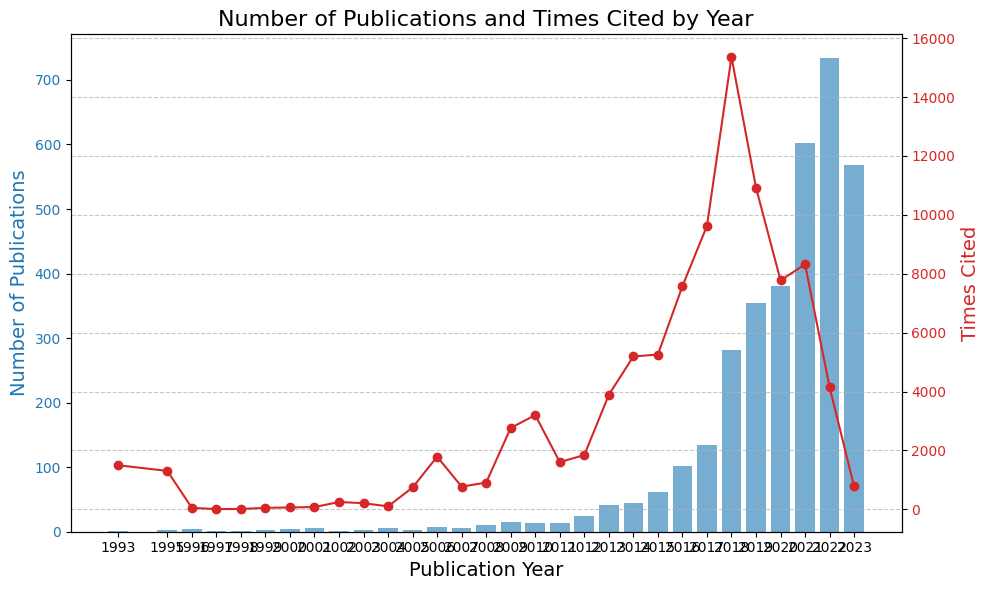

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd



year_counts = df['Year'].value_counts().sort_index()
citation_per_year = df.groupby('Year')['Cite'].sum()

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Publication Year', fontsize=14)
ax1.set_ylabel('Number of Publications', fontsize=14, color=color)
ax1.bar(year_counts.index, year_counts.values, color=color, label='Number of Publications', alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Times Cited', fontsize=14, color=color)
ax2.plot(citation_per_year.index, citation_per_year.values, marker='o', linestyle='-', color=color, label='Times Cited')
ax2.tick_params(axis='y', labelcolor=color)

plt.xticks(year_counts.index)

plt.title('Number of Publications and Times Cited by Year', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
fig.tight_layout()
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


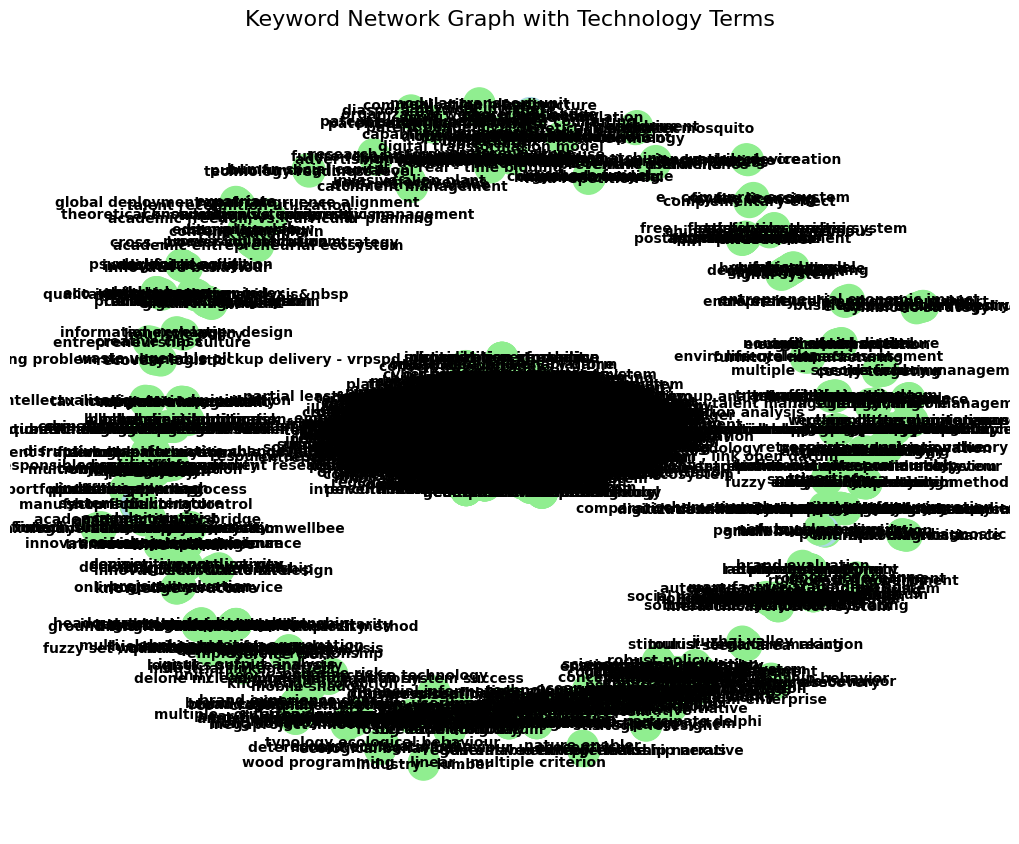

In [ ]:
import pandas as pd
import re
import spacy
import nltk
import networkx as nx
import matplotlib.pyplot as plt
from nltk.corpus import stopwords


nlp = spacy.load("en_core_web_sm")
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

with open('technologies.txt', 'r') as f:
    technology_list = [line.strip().lower() for line in f]


def preprocess_keywords(text):
    if not isinstance(text, str):
        return []
    # Step 1: Remove anything inside parentheses (e.g., "machine learning (ml)" -> "machine learning")
    text = re.sub(r'\([^)]*\)', '', text).strip()

    # Step 2: Split by | separator to get individual keywords
    keywords = text.split('|')

    cleaned_keywords = []

    for keyword in keywords:
        keyword = keyword.lower().strip()  # Convert to lowercase and remove extra spaces

        # Step 3: Remove stopwords
        keyword_tokens = [word for word in keyword.split() if word not in stop_words]

        # Step 4: Remove standalone abbreviations (e.g., "CNN")
        keyword_cleaned = re.sub(r'\b[A-Z]{2,}\b', '', ' '.join(keyword_tokens)).strip()

        # Step 5: Lemmatize the words to convert plural to singular
        doc = nlp(keyword_cleaned)
        keyword_lemmatized = ' '.join([token.lemma_ for token in doc])

        # Step 6: Keep non-empty keywords (numeric keywords will be removed after the network creation)
        if keyword_lemmatized and not re.search(r'\d', keyword_lemmatized):  # Ensure no numbers are present
            cleaned_keywords.append(keyword_lemmatized)

    return list(set(cleaned_keywords))  # Remove duplicate keywords


df['Processed Keywords'] = df['Keywords'].apply(preprocess_keywords)


G = nx.Graph()

for keywords in df['Processed Keywords']:

    keywords = [keyword for keyword in keywords if keyword and not re.search(r'\d', keyword)]

    for i in range(len(keywords)):
        for j in range(i + 1, len(keywords)):
            G.add_edge(keywords[i], keywords[j])


            if keywords[i] in technology_list:
                G.nodes[keywords[i]]['type'] = 'technology'
            else:
                G.nodes[keywords[i]]['type'] = 'general'

            if keywords[j] in technology_list:
                G.nodes[keywords[j]]['type'] = 'technology'
            else:
                G.nodes[keywords[j]]['type'] = 'general'

nodes_to_remove = [node for node in G.nodes() if node.isdigit() or node == '']
G.remove_nodes_from(nodes_to_remove)

plt.figure(figsize=(10, 8))

pos = nx.spring_layout(G, seed=42)

node_colors = ['lightblue' if G.nodes[node]['type'] == 'technology' else 'lightgreen' for node in G.nodes()]

nx.draw(G, pos, with_labels=True, node_size=500, node_color=node_colors, font_size=10, font_weight="bold", edge_color="gray")

plt.title("Keyword Network Graph with Technology Terms", fontsize=16)

plt.show()

nx.write_graphml(G, 'keywords_network_with_technologies.graphml')


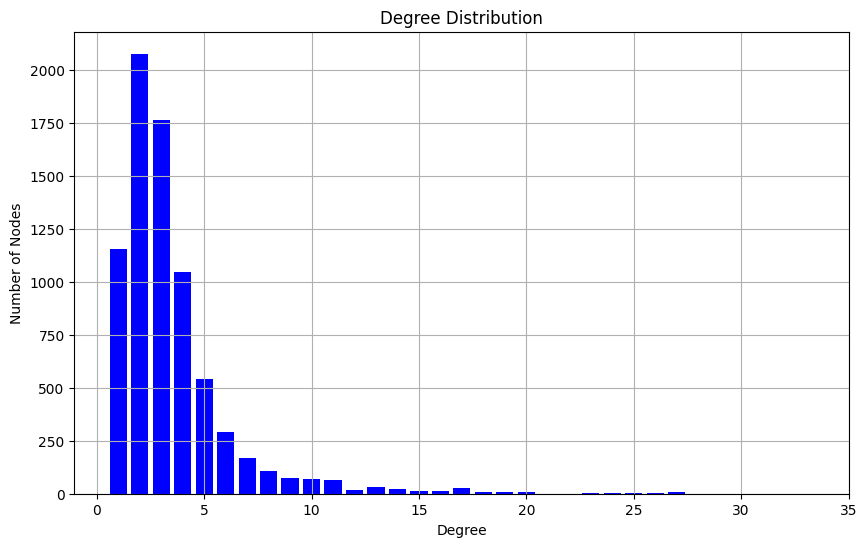

                     Metric     Value
0           Number of Nodes      7519
1           Number of Edges     13000
2                   Density   0.00046
3       Average Path Length  8.725803
4             Assortativity  0.435717
5    Clustering Coefficient  0.761603
6              Transitivity  0.656485
7       Power-law fit slope -2.513035
8   Power-law fit intercept  9.523532
9       Power-law R-squared  0.899422
10            Power-law fit  Good fit


In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter


def compute_network_metrics(G):

    metrics = {}


    metrics['Number of Nodes'] = G.number_of_nodes()
    metrics['Number of Edges'] = G.number_of_edges()
    metrics['Density'] = nx.density(G)


    if nx.is_connected(G):
        metrics['Average Path Length'] = nx.average_shortest_path_length(G)
    else:
        largest_cc = max(nx.connected_components(G), key=len)
        G_largest_cc = G.subgraph(largest_cc)
        metrics['Average Path Length'] = nx.average_shortest_path_length(G_largest_cc)


    metrics['Assortativity'] = nx.degree_assortativity_coefficient(G)


    metrics['Clustering Coefficient'] = nx.average_clustering(G)
    metrics['Transitivity'] = nx.transitivity(G)

    return metrics


def plot_degree_distribution_and_fit(G):

    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree distribution


    degree_count = Counter(degree_sequence)
    deg, cnt = zip(*degree_count.items())


    plt.figure(figsize=(10, 6))
    plt.bar(deg, cnt, color='blue')
    plt.xlabel('Degree')
    plt.ylabel('Number of Nodes')
    plt.title('Degree Distribution')
    plt.grid(True)
    plt.show()


    try:
        log_deg = np.log(deg)
        log_cnt = np.log(cnt)

        #
        fit = np.polyfit(log_deg, log_cnt, 1)
        slope, intercept = fit

        #
        p = np.poly1d(fit)
        yhat = p(log_deg)
        ybar = np.mean(log_cnt)
        ssreg = np.sum((yhat - ybar) ** 2)
        sstot = np.sum((log_cnt - ybar) ** 2)
        r_squared = ssreg / sstot

        # Decide if it's a good fit (R-squared > 0.8 is a good fit)
        power_law_fit = 'Good fit' if r_squared > 0.8 else 'Poor fit'

        return {
            'Power-law fit slope': slope,
            'Power-law fit intercept': intercept,
            'Power-law R-squared': r_squared,
            'Power-law fit': power_law_fit
        }
    except Exception as e:
        return {'Power-law fit error': str(e)}


G = nx.read_graphml('/content/C--authorship_network.graphml')


network_metrics = compute_network_metrics(G)


power_law_metrics = plot_degree_distribution_and_fit(G)


combined_metrics = {**network_metrics, **power_law_metrics}


metrics_df = pd.DataFrame(combined_metrics.items(), columns=['Metric', 'Value'])


print(metrics_df)


In [ ]:
import networkx as nx
import pandas as pd

# Function to calculate centrality metrics for all nodes
def compute_node_metrics(G):
    # Compute node-level centrality measures
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality(G)

    # Create a DataFrame to store all centrality measures for each node
    metrics_df = pd.DataFrame({
        'Node': list(G.nodes()),
        'Degree Centrality': [degree_centrality[node] for node in G.nodes()],
        'Betweenness Centrality': [betweenness_centrality[node] for node in G.nodes()],
        'Closeness Centrality': [closeness_centrality[node] for node in G.nodes()],
        'Eigenvector Centrality': [eigenvector_centrality[node] for node in G.nodes()]
    })

    return metrics_df

# Function to get the top 20 nodes sorted by degree centrality
def top_20_by_degree_centrality(metrics_df):
    top_20_df = metrics_df.sort_values(by='Degree Centrality', ascending=False).head(20)
    return top_20_df

# Load the graph from a GraphML file (replace with the actual path to your GraphML file)
G = nx.read_graphml('/content/C--authorship_network.graphml')

# Compute centrality metrics for all nodes
metrics_df = compute_node_metrics(G)

# Get the top 20 nodes sorted by degree centrality
top_20_df = top_20_by_degree_centrality(metrics_df)

# Save the full table to an Excel file
file_path = '/content/node_metrics.xlsx'
metrics_df.to_excel(file_path, index=False)

# Display the top 20 nodes in the console
print("Top 20 Nodes by Degree Centrality:")
print(top_20_df)

# Provide file path for download
file_path


Top 20 Nodes by Degree Centrality:
                    Node  Degree Centrality  Betweenness Centrality  \
289              Rong, K           0.004389                0.013828   
1902           Parida, V           0.004256                0.006683   
61               Chen, J           0.003591                0.005229   
1673            Gupta, S           0.003591                0.004661   
388        Chesbrough, H           0.003591                0.001314   
629          Di Minin, A           0.003591                0.010711   
567   McColl-Kennedy, JR           0.003591                0.004639   
571        Edvardsson, B           0.003591                0.002748   
278           Gallan, AS           0.003458                0.005205   
859        Audretsch, DB           0.003458                0.006151   
298            Ritala, P           0.003458                0.004216   
305            Vargo, SL           0.003325                0.004989   
820              Brem, A           0.00332

'/content/node_metrics.xlsx'

In [ ]:
import networkx as nx
import community.community_louvain as community_louvain
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms import approximation as approx


def load_graph(graphml_file):
    G = nx.read_graphml(graphml_file)
    G.remove_edges_from(nx.selfloop_edges(G))  # Remove self-loops
    return G


def calculate_modularity_and_communities(G):
    partition = community_louvain.best_partition(G)
    modularity = community_louvain.modularity(partition, G)
    return partition, modularity


def label_communities(G, partition):
    for node, community in partition.items():
        G.nodes[node]['community'] = community

def find_cliques(G):
    cliques = list(nx.find_cliques(G))
    return cliques

def detect_core_periphery(G):
    core_nodes = nx.k_core(G).nodes()
    periphery_nodes = [node for node in G.nodes() if node not in core_nodes]
    return core_nodes, periphery_nodes

def calculate_betweenness_centrality(G):
    betweenness = nx.betweenness_centrality(G)
    return betweenness

def detect_communities(G):
    communities = greedy_modularity_communities(G)
    return communities

def save_graph_with_communities(G, output_file):
    nx.write_graphml(G, output_file)
    print(f"Graph saved with community labels in {output_file}")

def analyze_graph(graphml_file, output_file):
    G = load_graph(graphml_file)

    partition, modularity = calculate_modularity_and_communities(G)
    print(f"Modularity: {modularity}")
    print(f"Communities detected (using Louvain): {len(set(partition.values()))}")

    label_communities(G, partition)

    cliques = find_cliques(G)
    print(f"Number of cliques found: {len(cliques)}")

    core_nodes, periphery_nodes = detect_core_periphery(G)
    print(f"Core nodes: {len(core_nodes)}, Periphery nodes: {len(periphery_nodes)}")

    betweenness = calculate_betweenness_centrality(G)
    top_bridging_nodes = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:5]
    print("Top 5 bridging nodes based on betweenness centrality:")
    for node, value in top_bridging_nodes:
        print(f"Node: {node}, Betweenness Centrality: {value}")


    save_graph_with_communities(G, output_file)

graphml_file = "/content/giant_component.graphml"
output_file = "graph_with_communities.graphml"
analyze_graph(graphml_file, output_file)
